# Regional ridge regression - surface temperature

In [27]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import numpy as np
import pandas as pd
import xarray as xr
from utils import *

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn import metrics


import warnings
warnings.filterwarnings('ignore')

In [2]:
# training sets
y_train = xr.open_dataset('/glade/u/home/ianderson/train_test/y_train_outputs.nc')
X = xr.concat([xr.open_dataset('/glade/u/home/ianderson/inputs/inputs_historical.nc'),xr.open_dataset('/glade/u/home/ianderson/inputs/inputs_ssp126.nc'),xr.open_dataset('/glade/u/home/ianderson/inputs/inputs_ssp370.nc'),xr.open_dataset('/glade/u/home/ianderson/inputs/inputs_ssp585.nc')], dim='time')
X["time"]=np.arange(1,424) 

In [3]:
def get_regional_df(da):
    # Roll the longitude to -180 to 180
    da = da.assign_coords(longitude=(((da.longitude + 180) % 360) - 180))
    da = da.roll(longitude=int(len(da['longitude']) / 2), roll_coords=True)

    # Get the average from four main emission regions
    north_america = da.sel(latitude=slice(25, 60), longitude=slice(-130, -60)).mean(['latitude', 'longitude']).assign_coords({'region': "NA"})
    europe = da.sel(latitude=slice(30, 75), longitude=slice(-10, 40)).mean(['latitude', 'longitude']).assign_coords({'region': "EU"})
    south_asia = da.sel(latitude=slice(5, 30), longitude=slice(65, 100)).mean(['latitude', 'longitude']).assign_coords({'region': "SA"})
    east_asia = da.sel(latitude=slice(20, 50), longitude=slice(100, 145)).mean(['latitude', 'longitude']).assign_coords({'region': "EA"})

    # Stack them back together
    ds = xr.concat([north_america, europe, south_asia, east_asia], dim='region') 
    df = ds.to_dataframe()[['SO2', 'BC']].unstack('region') # Get rid of the other variables and unstack the region dimension
    df.columns = df.columns.map(lambda x: '_'.join([str(i) for i in x])) # Flatten the multiindex
    return df * 1000*100 * 60*60*24*365 * 1e-12 * 510.1 * 1e6# kg -> Gt

In [4]:
# Bring the emissions data back together again and normalise
leading_historical_inputs = X[['CO2', 'CH4']].to_dataframe()

leading_historical_inputs=pd.concat([leading_historical_inputs, get_regional_df(X)], axis=1)

In [5]:
leading_historical_inputs

,CO2,CH4,SO2_NA,SO2_EU,SO2_SA,SO2_EA,BC_NA,BC_EU,BC_SA,BC_EA
time,,,,,,,,,,
1,0.188297,0.031306,0.000546,0.005329,0.000287,0.000242,0.000169,0.000673,0.000846,0.001036
2,0.377244,0.031742,0.000663,0.005234,0.000289,0.000241,0.000176,0.000678,0.000850,0.001029
3,0.573814,0.032178,0.000717,0.005360,0.000291,0.000241,0.000182,0.000695,0.000855,0.001022
4,0.778848,0.032614,0.000799,0.005455,0.000293,0.000240,0.000189,0.000712,0.000860,0.001015
5,1.020320,0.033049,0.000877,0.006273,0.000296,0.000239,0.000195,0.000774,0.000866,0.001008
...,...,...,...,...,...,...,...,...,...,...
419,8849.364057,0.477741,0.004896,0.012144,0.019095,0.018574,0.000255,0.000512,0.000832,0.001755
420,8978.159279,0.474618,0.004848,0.011931,0.017539,0.018223,0.000249,0.000497,0.000786,0.001700
421,9106.629265,0.471496,0.004800,0.011717,0.015984,0.017871,0.000244,0.000481,0.000740,0.001646


In [6]:
# testing sets
X_test = xr.open_dataset('/glade/u/home/ianderson/inputs/inputs_ssp245.nc').compute()
y_test = xr.open_dataset('/glade/work/duncanwp/ClimateBench/outputs_ssp245.nc').mean(['member', 'month']).compute()
y_test = y_test.transpose('year', 'lat', 'lon')

test_inputs = X_test[['CO2', 'CH4']].to_dataframe()

test_inputs = pd.concat([test_inputs, get_regional_df(X_test)], axis=1)

In [9]:
# reshaping
y_train_tas = y_train['tas'].values.reshape(-1, 192 * 288)
tas_truth = y_test['tas']

In [10]:
# Linear regression
lr = LinearRegression()
lr_tas = lr.fit(leading_historical_inputs, y_train_tas)

In [11]:
l_tas = lr_tas.predict(test_inputs)
l_out_tas = l_tas.reshape(86, 192, 288)

print(f"RMSE at 2050: {get_rmse(tas_truth[35], l_out_tas[35]).mean()}")
print(f"RMSE at 2100: {get_rmse(tas_truth[85], l_out_tas[85]).mean()}")
print(f"RMSE 2045-2055: {get_rmse(tas_truth[30:41], l_out_tas[30:41]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(tas_truth[75:], l_out_tas[75:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(tas_truth[35:], l_out_tas[35:]).mean()}")

RMSE at 2050: 0.37594529660206943
RMSE at 2100: 1.4340286457346347
RMSE 2045-2055: 0.4338746909111567
RMSE 2090-2100: 1.4132045566694782
RMSE 2050-2100: 1.0823888249323068


In [22]:
# Ridge regression
rr = Ridge(alpha = 0.5)
ridge_tas = rr.fit(leading_historical_inputs, y_train_tas)

r_tas = ridge_tas.predict(test_inputs)
r_out_tas = r_tas.reshape(86, 192, 288)


print(f"RMSE at 2050: {get_rmse(tas_truth[35], r_out_tas[35]).mean()}")
print(f"RMSE at 2100: {get_rmse(tas_truth[85], r_out_tas[85]).mean()}")
print(f"RMSE 2045-2055: {get_rmse(tas_truth[30:41], r_out_tas[30:41]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(tas_truth[75:], r_out_tas[75:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(tas_truth[35:], r_out_tas[35:]).mean()}")

RMSE at 2050: 0.3399055293864974
RMSE at 2100: 0.48000771625060557
RMSE 2045-2055: 0.4110925263850494
RMSE 2090-2100: 0.4654472214921406
RMSE 2050-2100: 0.4719690455418817


In [23]:
# Plotting coefficients
tas_coef = ridge_tas.coef_
print(tas_coef.shape)

(55296, 10)


In [25]:
tas_coefs = tas_coef.reshape(192, 288, 10)

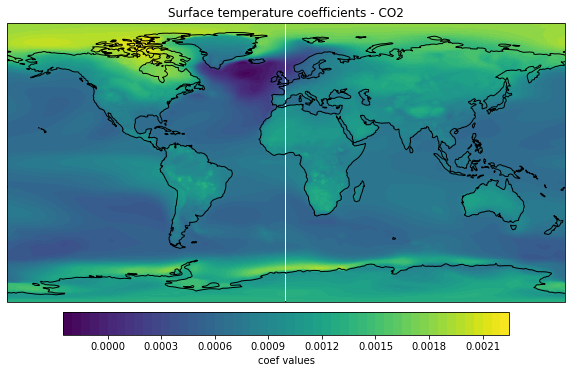

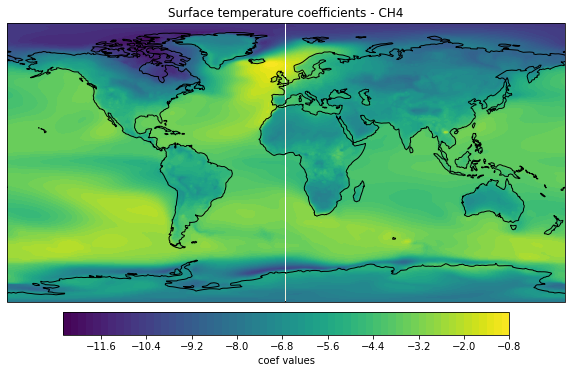

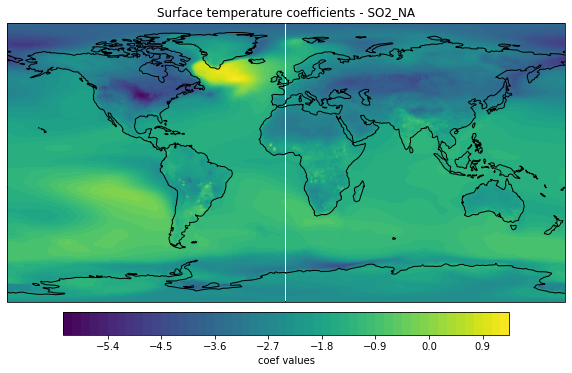

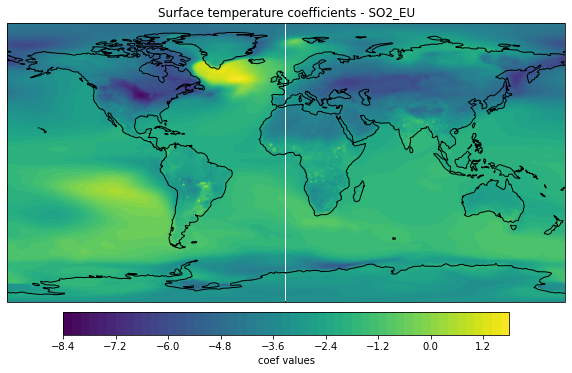

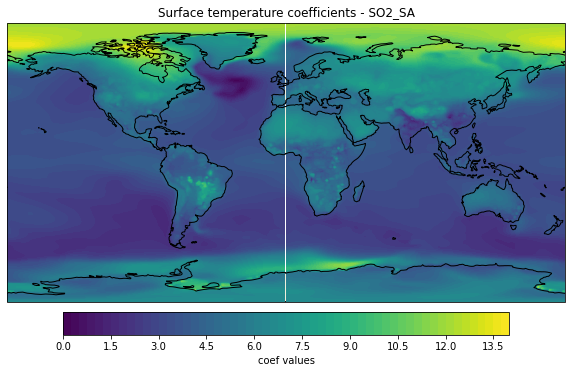

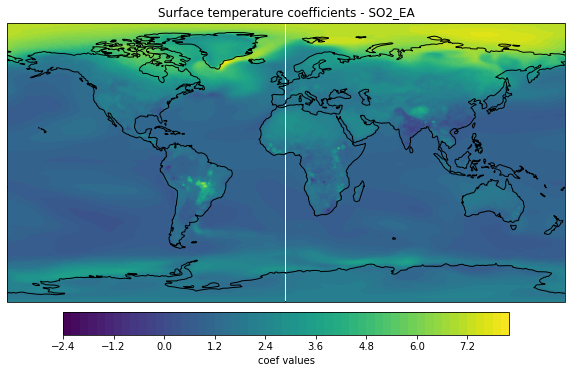

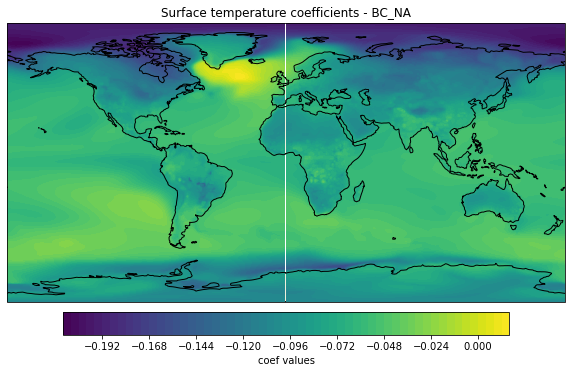

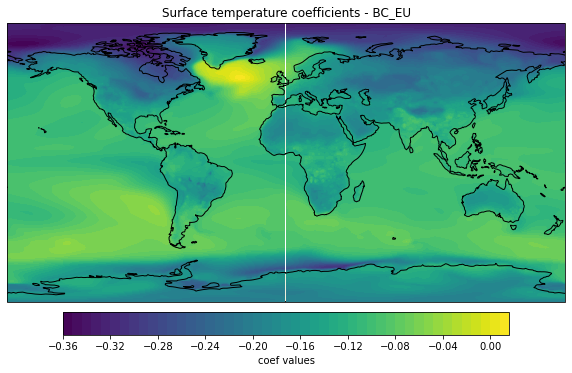

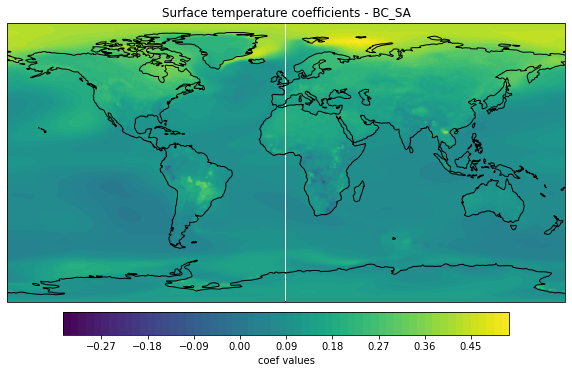

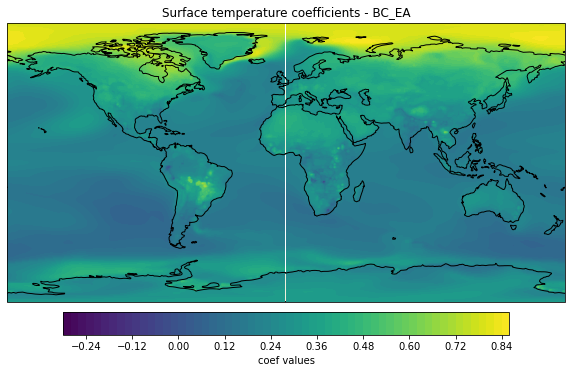

In [28]:
lat_vals = y_train['lat']
lon_vals = y_train['lon']

feature_names=['CO2', 'CH4', 'SO2_NA', 'SO2_EU', 'SO2_SA', 'SO2_EA', 'BC_NA', 'BC_EU', 'BC_SA', 'BC_EA']
for i in range(len(feature_names)):
    
    plt.figure(figsize=(10, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    # ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.LAND, edgecolor='black')

    plt.contourf(lon_vals, lat_vals, tas_coefs[:,:,i], 60)

    cbar = plt.colorbar(ax=ax, label='coef values', orientation='horizontal', shrink=0.8, pad=0.02)

    plt.title(f"Surface temperature coefficients - {feature_names[i]}")
    plt.show()
